In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.utils import *
from sklearn.preprocessing import *
import keras.backend as K

Using TensorFlow backend.
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [11]:
China_concat = pd.read_csv('../data/Concat/China_concat.csv', header=0)
Asia_concat = pd.read_csv('../data/Concat/Asia_concat.csv', header=0)
America_concat = pd.read_csv('../data/Concat/America_concat.csv', header=0)
Africa_concat = pd.read_csv('../data/Concat/Africa_concat.csv', header=0)
Europe_concat = pd.read_csv('../data/Concat/Europe_concat.csv', header=0)
Oceania_concat = pd.read_csv('../data/Concat/Oceania_concat.csv', header=0)

In [23]:
China_concat[:-7].sum()[1:3]

Daily_confirmed    83940.0
Daily_deaths        4637.0
dtype: float64

In [24]:
Asia_concat[:-7].sum()[1:3]

Daily_confirmed    300337
Daily_deaths        10233
dtype: int64

In [25]:
America_concat[:-7].sum()[1:3]

Daily_confirmed    1200849
Daily_deaths         67644
dtype: int64

In [26]:
Africa_concat[:-7].sum()[1:3]

Daily_confirmed    34921.0
Daily_deaths        1524.0
dtype: float64

In [27]:
Europe_concat[:-7].sum()[1:3]

Daily_confirmed    1378647.0
Daily_deaths        133031.0
dtype: float64

In [28]:
Oceania_concat[:-7].sum()[1:3]

Daily_confirmed    7908.0
Daily_deaths        107.0
dtype: float64

In [4]:
def make_df(DataFrame) : 
    df = pd.DataFrame()

    df['Confirm'] = (DataFrame['Daily confirmed cases (cases)'] + DataFrame['Daily confirmed deaths (deaths)']) / DataFrame['Total confirmed cases (cases)']
    df['Flight'] = DataFrame['Passenger_arrivals'] / DataFrame['Flight_arrivals']
    df['Ship'] = ( DataFrame['Ship_crew(korea)'] + DataFrame['Ship_crew(foreign)'] + DataFrame['Ship_passenger'] ) / DataFrame['Ship_count']
    df['News'] = DataFrame['News_Negative'] / DataFrame['News_Sum']
    df['Date'] = DataFrame['Date'].astype(int)
    df['label'] = DataFrame[DataFrame.columns[-1]]


    df.fillna(0, inplace = True)
    df.set_index('Date',inplace=True)

    df = df.loc[20200101:20200428]
    
    return df

In [5]:
def make_train_test(tmp_df) : 
    df = tmp_df[:][:]
    
    shift_size = 14
    for s in range(1, shift_size+1):
        df['shift_{}'.format(s)] = df['Data'].shift(s)
        
    
    
    
    y_train = np.asarray(df['Data'][shift_size:-2])
    y_test = np.asarray(df['Data'][-2:-1])
    
    y_check = np.asarray(df['Data'][-1:])
    
    df.drop('Data', axis=1, inplace=True)
        
    X_train = np.array(df[7:-2])
    X_test = np.array(df[-2:-1])
    
    sc = MinMaxScaler()

    train_sc = sc.fit_transform(X_train)
    test_sc = sc.transform(X_test)


    X_train_r = train_sc.reshape(train_sc.shape[0],train_sc.shape[1],1)
    X_test_r = test_sc.reshape(test_sc.shape[0],test_sc.shape[1],1)
    
    print(df)
    
    return X_train_r, X_test_r, y_train, y_test, y_check

In [6]:
df = make_df(Asia_concat)

Flight_df = pd.DataFrame(df['Flight'])
Flight_df.columns = ['Data']

Ship_df = pd.DataFrame(df['Ship'])
Ship_df.columns = ['Data']

Confirm_df = pd.DataFrame(df['Confirm'])
Confirm_df.columns = ['Data']

News_df = pd.DataFrame(df['Confirm'])
News_df.columns = ['Data']


X_train, X_test, y_train, y_test, y_check = make_train_test(Flight_df)

             shift_1     shift_2     shift_3     shift_4     shift_5  \
Date                                                                   
20200101         NaN         NaN         NaN         NaN         NaN   
20200102  170.626362         NaN         NaN         NaN         NaN   
20200103  170.722826  170.626362         NaN         NaN         NaN   
20200104  162.440043  170.722826  170.626362         NaN         NaN   
20200105  169.272436  162.440043  170.722826  170.626362         NaN   
...              ...         ...         ...         ...         ...   
20200424  124.242038  119.534426  117.193662  115.458746  102.432749   
20200425  113.284553  124.242038  119.534426  117.193662  115.458746   
20200426  117.567358  113.284553  124.242038  119.534426  117.193662   
20200427  128.948148  117.567358  113.284553  124.242038  119.534426   
20200428  139.930481  128.948148  117.567358  113.284553  124.242038   

             shift_6     shift_7  
Date                        

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.models import load_model


K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
xInput = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))
xLstm_1 = LSTM(20, return_sequences = True)(xInput)
xLstm_2 = Bidirectional(LSTM(20))(xLstm_1)
xOutput = Dense(1)(xLstm_2)


model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam',  metrics = [ 'mae' ])


 # 학습
early_stop = EarlyStopping(monitor='loss', patience=1, mode='auto')

model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=2, shuffle=False)

 # 예측
y_hat = model.predict(X_test, batch_size=1)


Epoch 1/500
 - 1s - loss: 16523.1617 - mae: 125.4777
Epoch 2/500
 - 0s - loss: 14155.8697 - mae: 115.9698
Epoch 3/500
 - 0s - loss: 12952.5271 - mae: 110.7100
Epoch 4/500
 - 0s - loss: 11932.6129 - mae: 106.0203
Epoch 5/500
 - 0s - loss: 11010.6898 - mae: 101.5897
Epoch 6/500
 - 0s - loss: 10162.4015 - mae: 97.3330
Epoch 7/500
 - 0s - loss: 9376.2074 - mae: 93.2137
Epoch 8/500
 - 0s - loss: 8645.1050 - mae: 89.2120
Epoch 9/500
 - 0s - loss: 7964.2031 - mae: 85.3165
Epoch 10/500
 - 0s - loss: 7329.8162 - mae: 81.5197
Epoch 11/500
 - 0s - loss: 6738.8741 - mae: 77.8166
Epoch 12/500
 - 0s - loss: 6188.7664 - mae: 74.2037
Epoch 13/500
 - 0s - loss: 5677.2052 - mae: 70.6787
Epoch 14/500
 - 0s - loss: 5202.0941 - mae: 67.2398
Epoch 15/500
 - 0s - loss: 4761.5067 - mae: 63.8860
Epoch 16/500
 - 0s - loss: 4353.6517 - mae: 60.6166
Epoch 17/500
 - 0s - loss: 3976.8377 - mae: 57.4314
Epoch 18/500
 - 0s - loss: 3629.4588 - mae: 54.3303
Epoch 19/500
 - 0s - loss: 3309.9734 - mae: 51.3137
Epoch 20/

Epoch 159/500
 - 0s - loss: 75.5972 - mae: 6.9585
Epoch 160/500
 - 0s - loss: 70.2960 - mae: 6.5629
Epoch 161/500
 - 0s - loss: 71.1394 - mae: 6.6692
Epoch 162/500
 - 0s - loss: 67.8055 - mae: 6.4553
Epoch 163/500
 - 0s - loss: 67.5887 - mae: 6.4617
Epoch 164/500
 - 0s - loss: 67.3573 - mae: 6.4514
Epoch 165/500
 - 0s - loss: 67.6723 - mae: 6.4685
Epoch 166/500
 - 0s - loss: 70.3278 - mae: 6.6044
Epoch 167/500
 - 0s - loss: 72.8139 - mae: 6.7190
Epoch 168/500
 - 0s - loss: 70.7040 - mae: 6.6598
Epoch 169/500
 - 0s - loss: 68.5297 - mae: 6.5116
Epoch 170/500
 - 0s - loss: 71.0022 - mae: 6.6184
Epoch 171/500
 - 0s - loss: 67.6147 - mae: 6.4573
Epoch 172/500
 - 0s - loss: 68.4984 - mae: 6.5241
Epoch 173/500
 - 0s - loss: 67.0488 - mae: 6.4337
Epoch 174/500
 - 0s - loss: 66.8655 - mae: 6.4214
Epoch 175/500
 - 0s - loss: 66.2052 - mae: 6.4040
Epoch 176/500
 - 0s - loss: 71.0619 - mae: 6.6215
Epoch 177/500
 - 0s - loss: 67.4169 - mae: 6.5163
Epoch 178/500
 - 0s - loss: 65.1008 - mae: 6.3385


Epoch 323/500
 - 0s - loss: 53.9293 - mae: 5.6553
Epoch 324/500
 - 0s - loss: 58.3753 - mae: 5.8576
Epoch 325/500
 - 0s - loss: 56.0412 - mae: 5.8382
Epoch 326/500
 - 0s - loss: 54.2360 - mae: 5.6858
Epoch 327/500
 - 0s - loss: 53.9040 - mae: 5.6484
Epoch 328/500
 - 0s - loss: 53.9714 - mae: 5.6502
Epoch 329/500
 - 0s - loss: 54.6925 - mae: 5.6761
Epoch 330/500
 - 0s - loss: 54.9476 - mae: 5.7547
Epoch 331/500
 - 0s - loss: 54.0535 - mae: 5.7303
Epoch 332/500
 - 0s - loss: 54.0320 - mae: 5.7139
Epoch 333/500
 - 0s - loss: 53.5971 - mae: 5.6926
Epoch 334/500
 - 0s - loss: 54.3393 - mae: 5.7266
Epoch 335/500
 - 0s - loss: 54.9603 - mae: 5.7384
Epoch 336/500
 - 0s - loss: 53.6008 - mae: 5.6470
Epoch 337/500
 - 0s - loss: 53.8920 - mae: 5.6575
Epoch 338/500
 - 0s - loss: 53.6152 - mae: 5.6393
Epoch 339/500
 - 0s - loss: 53.6113 - mae: 5.6370
Epoch 340/500
 - 0s - loss: 53.5328 - mae: 5.6384
Epoch 341/500
 - 0s - loss: 53.3339 - mae: 5.6359
Epoch 342/500
 - 0s - loss: 53.6896 - mae: 5.6502


Epoch 487/500
 - 0s - loss: 47.4838 - mae: 5.3030
Epoch 488/500
 - 0s - loss: 50.9869 - mae: 5.5696
Epoch 489/500
 - 0s - loss: 47.2003 - mae: 5.2495
Epoch 490/500
 - 0s - loss: 47.7640 - mae: 5.3587
Epoch 491/500
 - 0s - loss: 52.0108 - mae: 5.4823
Epoch 492/500
 - 0s - loss: 48.3677 - mae: 5.2961
Epoch 493/500
 - 0s - loss: 49.8069 - mae: 5.3579
Epoch 494/500
 - 0s - loss: 46.6335 - mae: 5.2507
Epoch 495/500
 - 0s - loss: 49.3907 - mae: 5.3675
Epoch 496/500
 - 0s - loss: 46.9151 - mae: 5.2240
Epoch 497/500
 - 0s - loss: 49.2976 - mae: 5.3735
Epoch 498/500
 - 0s - loss: 46.4122 - mae: 5.2300
Epoch 499/500
 - 0s - loss: 50.2323 - mae: 5.4249
Epoch 500/500
 - 0s - loss: 49.0075 - mae: 5.3060


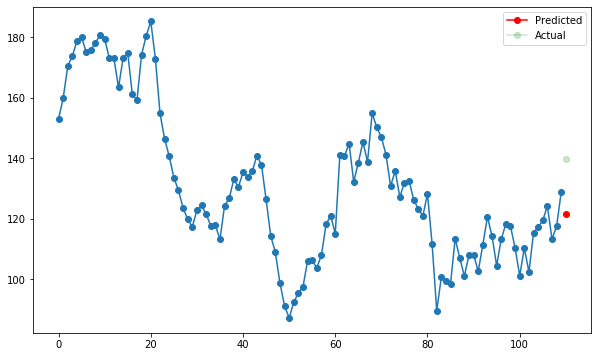

In [8]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(110 ,), 'o-')
plt.plot(b_axis, y_hat.reshape(1,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(1,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

In [9]:
y_hat

array([[121.72329]], dtype=float32)

In [10]:
y_test

array([139.93048128])

In [11]:
Flight_df = Flight_df[:-2]

In [12]:
Flight_df.loc[20200427] = y_hat[0][0]

In [13]:
Flight_df.loc[20200428] = 0

In [19]:
Flight_df

,Data
Date,
20200101,170.626362
20200102,170.722826
20200103,162.440043
20200104,169.272436
20200105,175.246040
...,...
20200424,113.284553
20200425,117.567358
20200426,128.948148


In [20]:
df = Flight_df[:][:]

for s in range(1, 8):
    df['shift_{}'.format(s)] = df['Data'].shift(s)

y_train = np.asarray(df['Data'][7:-1])
y_test = np.asarray(df['Data'][-1:])

df.drop('Data', axis=1, inplace=True)

X_train = np.array(df[7:-1])
X_test = np.array(df[-1:])

sc = MinMaxScaler()

train_sc = sc.fit_transform(X_train)
test_sc = sc.transform(X_test)


X_train_r = train_sc.reshape(train_sc.shape[0],train_sc.shape[1],1)
X_test_r = test_sc.reshape(test_sc.shape[0],test_sc.shape[1],1)

                   
                   
K.clear_session()  
xInput = Input(batch_shape=(None, X_train_r.shape[1], X_train_r.shape[2]))
xLstm_1 = LSTM(20, return_sequences = True)(xInput)
xLstm_2 = Bidirectional(LSTM(20))(xLstm_1)
xOutput = Dense(1)(xLstm_2)


model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam',  metrics = [ 'mae' ])


 # 학습
early_stop = EarlyStopping(monitor='loss', patience=1, mode='auto')

model.fit(X_train_r, y_train, epochs=500, batch_size=1, verbose=2, shuffle=False)

 # 예측


Epoch 1/500
 - 1s - loss: 16392.8469 - mae: 124.9095
Epoch 2/500
 - 0s - loss: 13936.1266 - mae: 115.0458
Epoch 3/500
 - 0s - loss: 12747.3129 - mae: 109.8036
Epoch 4/500
 - 0s - loss: 11733.0756 - mae: 105.0999
Epoch 5/500
 - 0s - loss: 10815.2935 - mae: 100.6491
Epoch 6/500
 - 0s - loss: 9970.8426 - mae: 96.3707
Epoch 7/500
 - 0s - loss: 9188.5461 - mae: 92.2295
Epoch 8/500
 - 0s - loss: 8461.6063 - mae: 88.2069
Epoch 9/500
 - 0s - loss: 7785.1729 - mae: 84.2914
Epoch 10/500
 - 0s - loss: 7155.5574 - mae: 80.4760
Epoch 11/500
 - 0s - loss: 6569.6995 - mae: 76.7557
Epoch 12/500
 - 0s - loss: 6024.9760 - mae: 73.1272
Epoch 13/500
 - 0s - loss: 5519.0675 - mae: 69.5883
Epoch 14/500
 - 0s - loss: 5049.8600 - mae: 66.1375
Epoch 15/500
 - 0s - loss: 4615.3928 - mae: 62.7736
Epoch 16/500
 - 0s - loss: 4213.8453 - mae: 59.4962
Epoch 17/500
 - 0s - loss: 3843.4872 - mae: 56.3050
Epoch 18/500
 - 0s - loss: 3502.6777 - mae: 53.2002
Epoch 19/500
 - 0s - loss: 3189.8399 - mae: 50.1820
Epoch 20/50

Epoch 163/500
 - 0s - loss: 70.5774 - mae: 6.6586
Epoch 164/500
 - 0s - loss: 72.3644 - mae: 6.7139
Epoch 165/500
 - 0s - loss: 72.1723 - mae: 6.6465
Epoch 166/500
 - 0s - loss: 71.2450 - mae: 6.6728
Epoch 167/500
 - 0s - loss: 70.3213 - mae: 6.5982
Epoch 168/500
 - 0s - loss: 70.9176 - mae: 6.5881
Epoch 169/500
 - 0s - loss: 75.6124 - mae: 6.7521
Epoch 170/500
 - 0s - loss: 68.2693 - mae: 6.5548
Epoch 171/500
 - 0s - loss: 74.8484 - mae: 6.7205
Epoch 172/500
 - 0s - loss: 67.9016 - mae: 6.5378
Epoch 173/500
 - 0s - loss: 73.3836 - mae: 6.6932
Epoch 174/500
 - 0s - loss: 75.6615 - mae: 6.9666
Epoch 175/500
 - 0s - loss: 69.7868 - mae: 6.5815
Epoch 176/500
 - 0s - loss: 67.0538 - mae: 6.4415
Epoch 177/500
 - 0s - loss: 68.4073 - mae: 6.5161
Epoch 178/500
 - 0s - loss: 73.4291 - mae: 6.6779
Epoch 179/500
 - 0s - loss: 67.4718 - mae: 6.5209
Epoch 180/500
 - 0s - loss: 72.7389 - mae: 6.6854
Epoch 181/500
 - 0s - loss: 73.2488 - mae: 6.8709
Epoch 182/500
 - 0s - loss: 70.8945 - mae: 6.6545


Epoch 327/500
 - 0s - loss: 57.8664 - mae: 5.9358
Epoch 328/500
 - 0s - loss: 55.5903 - mae: 5.7761
Epoch 329/500
 - 0s - loss: 54.9098 - mae: 5.6699
Epoch 330/500
 - 0s - loss: 54.1634 - mae: 5.5751
Epoch 331/500
 - 0s - loss: 55.0261 - mae: 5.7126
Epoch 332/500
 - 0s - loss: 54.6991 - mae: 5.6494
Epoch 333/500
 - 0s - loss: 54.7535 - mae: 5.6420
Epoch 334/500
 - 0s - loss: 55.4858 - mae: 5.7067
Epoch 335/500
 - 0s - loss: 54.6803 - mae: 5.6145
Epoch 336/500
 - 0s - loss: 55.1709 - mae: 5.6670
Epoch 337/500
 - 0s - loss: 54.5502 - mae: 5.6424
Epoch 338/500
 - 0s - loss: 53.8092 - mae: 5.6057
Epoch 339/500
 - 0s - loss: 54.1190 - mae: 5.6241
Epoch 340/500
 - 0s - loss: 53.7183 - mae: 5.5464
Epoch 341/500
 - 0s - loss: 53.6078 - mae: 5.5469
Epoch 342/500
 - 0s - loss: 53.6972 - mae: 5.5641
Epoch 343/500
 - 0s - loss: 53.5348 - mae: 5.5314
Epoch 344/500
 - 0s - loss: 53.4446 - mae: 5.5215
Epoch 345/500
 - 0s - loss: 53.2129 - mae: 5.5023
Epoch 346/500
 - 0s - loss: 53.5343 - mae: 5.5422


Epoch 491/500
 - 0s - loss: 48.7506 - mae: 5.2354
Epoch 492/500
 - 0s - loss: 48.0610 - mae: 5.3486
Epoch 493/500
 - 0s - loss: 46.0518 - mae: 5.0452
Epoch 494/500
 - 0s - loss: 46.2151 - mae: 5.0396
Epoch 495/500
 - 0s - loss: 45.4716 - mae: 4.9618
Epoch 496/500
 - 0s - loss: 46.2192 - mae: 5.1035
Epoch 497/500
 - 0s - loss: 48.3204 - mae: 5.0797
Epoch 498/500
 - 0s - loss: 46.9234 - mae: 5.1467
Epoch 499/500
 - 0s - loss: 45.3164 - mae: 4.9696
Epoch 500/500
 - 0s - loss: 45.8229 - mae: 5.0343


In [21]:
y_hat = model.predict(X_test_r, batch_size=1)

In [22]:
y_hat, y_check

(array([[119.11811]], dtype=float32), array([139.066313]))

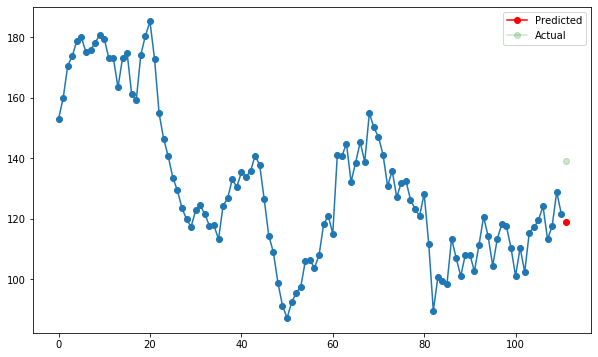

In [23]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(111 ,), 'o-')
plt.plot(b_axis, y_hat.reshape(1,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_check.reshape(1,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()